<a href="https://colab.research.google.com/github/itsGab/pred_uti_covid/blob/main/nb_pred_uti_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
# importando libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

# importando dados
raw_data = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
raw_data.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

# funcoes


In [ ]:
def remove_space(col):
    '''
    function to remove spaces between the columns names
    '''
    if ' ' in col:
        col = col.replace(' ', '_')
    return col


In [ ]:
def prepare_window(rows):
    '''
    prepara a janela com o resultado do ICU na primeira janela
    '''
    if np.any(rows['icu']):
        rows.loc[rows['window'] == '0-2', 'icu'] = 1
    return rows.loc[rows['window'] == '0-2']

In [ ]:
def remove_corr_var(dados, valor_corte):
    '''
    funcao para remover colunas com variaveis com correlacao
    '''
    matrix_corr = dados.iloc[:, 12:-11].corr().abs()
    matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
    excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]

    return dados.drop(excluir, axis=1), excluir

In [ ]:
def rem_cols_zero_std(df):
    '''
    removendo colunas que nao sofrem alteracao
    '''
    no_alt_cols = []
    temp_describe = df.query('window == "0-2"').describe(include='all')
    for col in df.columns:
        if temp_describe.loc['std', col] == 0:
            no_alt_cols.append(col)
    clean_df = df.drop(no_alt_cols, axis=1)
    return clean_df

In [ ]:
def semente(padrao=73246):
    '''
    utilizando como seed padrao
    '''
    np.random.seed(padrao)

In [ ]:
def roda_modelo(modelo, X, y, mostra=False):
    '''
    funcao que roda os modelos
    '''
    conta = 0
    semente()
    if conta <= 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    y_pred = modelo.fit(X_train, y_train).predict(X_test)
    conta += 1
    if mostra == True:
        print(15* '-----')
        print(modelo.__module__)
        print(15* '-----')
        print(classification_report(y_test, y_pred))
        print(15* '_____', '\n')
    return accuracy_score(y_test, y_pred)

# tratando dados

In [ ]:
# tratando colunas e algumas variaveis string
raw_data.columns = raw_data.columns.str.lower()
raw_data['window'] = raw_data['window'].str.lower()
raw_data['age_percentil'] = raw_data['age_percentil'].str.lower()
raw_data.columns = raw_data.columns.map(remove_space)
raw_data['age_percentil'] = raw_data['age_percentil'].map(remove_space)

In [ ]:
# lista de pacientes que foram para uti na primeira janela
id_icu_first_window = raw_data.query("window == '0-2' & icu == 1")['patient_visit_identifier'].unique()

# selecionando dataframe dos pacientes que nao foram para uti na primeira janela
clean_data = raw_data.query('patient_visit_identifier not in @id_icu_first_window')

# selecionando colunas com dados continuos e vazios e preenchendo
fill_cols = clean_data.iloc[:, 13:-2].columns
df_filling_cols = clean_data.groupby('patient_visit_identifier', as_index=False)[fill_cols].fillna(method='bfill').fillna(method='ffill')
clean_data[fill_cols] = df_filling_cols

# preparando dados com somente a primeira janela
clean_data = clean_data.groupby('patient_visit_identifier').apply(prepare_window)

# removendo colunas com std == 0
clean_data = rem_cols_zero_std(clean_data)

# usando det_dummies no age_percentil (categorical data)
clean_data = pd.get_dummies(clean_data, columns=['age_percentil'])

# jogando fora qualquer valor remanescente com valor NaN
clean_data = clean_data.dropna()

# removendo colunas com correlacao maior que 95%
clean_data, exc = remove_corr_var(clean_data, 0.95)

In [ ]:
# printando dataframe limpo
clean_data

,,patient_visit_identifier,age_above65,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other,albumin_median,be_arterial_median,be_venous_median,bic_arterial_median,bic_venous_median,billirubin_median,blast_median,calcium_median,creatinin_median,ffa_median,ggt_median,glucose_median,hematocrite_median,inr_median,lactate_median,leukocytes_median,linfocitos_median,p02_arterial_median,p02_venous_median,pc02_arterial_median,pc02_venous_median,pcr_median,ph_arterial_median,ph_venous_median,platelets_median,potassium_median,sat02_arterial_median,sat02_venous_median,sodium_median,tgo_median,tgp_median,ttpa_median,urea_median,dimer_median,bloodpressure_diastolic_mean,bloodpressure_sistolic_mean,heart_rate_mean,respiratory_rate_mean,temperature_mean,oxygen_saturation_mean,respiratory_rate_min,bloodpressure_diastolic_max,bloodpressure_diastolic_diff,bloodpressure_sistolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff,oxygen_saturation_diff,heart_rate_diff_rel,window,icu,age_percentil_10th,age_percentil_20th,age_percentil_30th,age_percentil_40th,age_percentil_50th,age_percentil_60th,age_percentil_70th,age_percentil_80th,age_percentil_90th,age_percentil_above_90th
patient_visit_identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,-0.932246,1.000000,-0.835844,-0.914938,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1,0,0,0,0,0,1,0,0,0,0
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,-0.959849,1.000000,-0.382773,-0.908714,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1,1,0,0,0,0,0,0,0,0,0
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.000000,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.959849,-0.828421,-0.729239,-0.836100,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0,0,0,1,0,0,0,0,0,0
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,-0.959849,1.000000,-0.702202,-0.641079,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,-0.592593,0.939394,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0,1,0,0,0,0,0,0,0,0,0
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.891012,-0.742004,-0.958528,-0.891993,0.291405,-0.959849,1.000000,-0.706450,-0.340249,-0.170732,-0.704142,-0.77931,-0.754601,-0.997732,0.234043,0.363636,-0.292390,-0.666667,0.939394,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.428571,-0.247863,-0.826087,-0

# calculando impacto das colunas na ida para icu

In [ ]:
# separando e listando dados categoricos e continuos
con_data = clean_data.describe().loc[['min', 'max'], :].iloc[:, 12:-11].columns
cat_data = clean_data.drop(con_data, axis=1).columns.tolist()
# removendo colunas da lista (deixei o icu de proposito)
cat_data.remove('patient_visit_identifier')
cat_data.remove('window')

CALCULANDO IMPACTO

## variaveis continuas

In [ ]:
# CALCULA IMPACTO DA CARACTERISTICA BASEADO NA MEDIA E SUA REPRESENTATIVIDADE NA AMOSTRA 
# DADOS CONTINUOS [-1, 1] - con_data

# cria dataframe vazio    
df_con = pd.DataFrame()

for coluna in con_data:

    # media
    media = clean_data.describe().loc['mean', coluna]

    # conta acima da media
    total_acima = 0
    for v in clean_data[coluna]:
        if v >= media:
            total_acima += 1

    # total acima da media que foram pra uti
    total_pos = clean_data.query(f'{coluna} >= {media}')['icu'].sum()
    perc_pos = total_pos / total_acima

    # total com que nao foram para uti
    total_neg = total_acima - total_pos
    perc_neg = total_neg / total_acima

    # representatividade da caracteristica
    total_geral = len(clean_data) # numero de pacientes total (com ou sem)
    repr = total_acima/total_geral

    # retorno separado ou um df ???
    media, coluna, perc_pos, perc_neg, total_acima, repr

    # cria Series e adiciona ao DF
    s = pd.Series(
        data = [media, perc_pos, perc_neg, total_geral, repr], 
        index = ['media', 'perc_pos', 'perc_neg', 'total_geral', 'repr'], 
        name=coluna
        )
    df_con = df_con.append(s)

Mostrando apenas os 10 primeiros, ordenados por mais porcentagem de pacientes acima da media que foram parar na UTI

---

Dicionario do DF abaixo
```
media: eh a media dos valores
perc_neg: eh o porcentagem de pacientes acima da media que NAO foram pra uti
perc_pos: eh a porcentagem de pacientes acima da media que FORAM pra uti
repr: eh a porcentagem de pacientes que estao com valor acima da media
total: tamanho da amostra total
```

In [ ]:
df_con.sort_values(by='perc_pos', ascending=False)[['media', 'perc_pos', 'perc_neg', 'repr'	,'total_geral']][:10]

,media,perc_pos,perc_neg,repr,total_geral
be_arterial_median,-0.998177,1.000000,0.000000,0.008523,352.0
blast_median,-0.993578,1.000000,0.000000,0.005682,352.0
p02_venous_median,-0.699133,0.698113,0.301887,0.150568,352.0
ggt_median,-0.937430,0.688889,0.311111,0.127841,352.0
ph_venous_median,0.383006,0.657143,0.342857,0.198864,352.0
ffa_median,-0.728951,0.645161,0.354839,0.088068,352.0
pcr_median,-0.809939,0.637931,0.362069,0.329545,352.0
urea_median,-0.850424,0.634921,0.365079,0.357955,352.0
respiratory_rate_min,-0.390422,0.632353,0.367647,0.386364,352.0
respiratory_rate_mean,-0.466596,0.617450,0.382550,0.423295,352.0


Talvez algumas valores estajam errados devido ao metodo que foi usado para preencher os dados faltantes (os NaN), alguns valores copiados podem ter sido de pacientes que ja se encontravam na UTI, causando assim um erro. Teria de ser feito novamente para ter certeza.

In [ ]:
# CALCULA IMPACTO DA CARACTERISTICA E SUA REPRESENTATIVIDADE NA AMOSTRA 
# DADOS CATEGORICOS [1, 0] - cat_data

# cria dataframe vazio    
df_cat = pd.DataFrame()

for coluna in cat_data:

    # total com caracteristica (coluna*)
    total_com = clean_data[coluna].sum()

    # total com que foram pra uti
    total_pos = clean_data.query(f'{coluna} == 1')['icu'].sum()
    perc_pos = total_pos / total_com

    # total com que nao foram para uti
    total_neg = total_com - total_pos
    perc_neg = total_neg / total_com

    # representatividade da caracteristica (coluna*)
    total_geral = len(clean_data) # numero de pacientes total (com ou sem)
    repr = total_com/total_geral

    # retorno separado ou um df ???
    coluna, total_com, perc_pos, perc_neg, repr

    # cria Series e adiciona ao DF
    s = pd.Series(
        data = [total_com, perc_pos, perc_neg, repr], 
        index = ['total_com', 'perc_pos', 'perc_neg', 'repr'], 
        name=coluna
        )
    df_cat = df_cat.append(s)

Mostrando apenas os 10 primeiros, ordenados por mais porcentagem de pacientes com caracteristica que foram parar na UTI

---

Dicionario do DF abaixo (caracteristica: nome da coluna)
```
media: eh a media dos valores
perc_neg: eh o porcentagem de pacientes com caracteristica que NAO foram pra uti
perc_pos: eh a porcentagem de pacientes com caracteristica que FORAM pra uti
repr: eh a porcentagem de pacientes que estao com caracteristica
total: tamanho da amostra com caracteristica da coluna
```

In [ ]:
df_cat.sort_values(by='perc_pos', ascending=False)[['perc_pos', 'perc_neg', 'repr', 'total_com']][:10]

,perc_pos,perc_neg,repr,total_com
icu,1.000000,0.000000,0.463068,163.0
disease_grouping_4,0.857143,0.142857,0.019886,7.0
age_percentil_above_90th,0.764706,0.235294,0.096591,34.0
disease_grouping_2,0.750000,0.250000,0.022727,8.0
age_percentil_90th,0.714286,0.285714,0.079545,28.0
age_percentil_80th,0.666667,0.333333,0.102273,36.0
disease_grouping_3,0.656250,0.343750,0.090909,32.0
htn,0.647059,0.352941,0.193182,68.0
disease_grouping_5,0.622222,0.377778,0.127841,45.0
age_above65,0.621118,0.378882,0.457386,161.0


## variaveis categoricas

In [ ]:
df_cat

,perc_neg,perc_pos,repr,total_com
age_above65,0.378882,0.621118,0.457386,161.0
gender,0.611940,0.388060,0.380682,134.0
disease_grouping_1,0.432432,0.567568,0.105114,37.0
disease_grouping_2,0.250000,0.750000,0.022727,8.0
disease_grouping_3,0.343750,0.656250,0.090909,32.0
disease_grouping_4,0.142857,0.857143,0.019886,7.0
disease_grouping_5,0.377778,0.622222,0.127841,45.0
disease_grouping_6,0.600000,0.400000,0.042614,15.0
htn,0.352941,0.647059,0.193182,68.0
immunocompromised,0.456140,0.543860,0.161932,57.0


In [ ]:
# disease_groupings
disease_groups = df_cat.iloc[2:8].index
# htn + immunocompromised + other
others = ['htn', 'immunocompromised', 'other']
# age_percentil + age_above65
age_percentil = df_cat.index[-10:]
# genero (masc, fem)
gender = ['gender']

## graficos de impacto das colunas

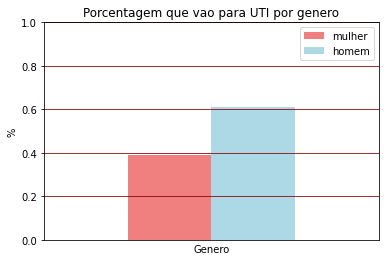

In [ ]:
ax = df_cat.loc[gender, ['perc_pos', 'perc_neg']].sort_values(by='perc_pos', ascending=False).plot(kind='bar', 
                                                                                          ylabel='%',
                                                                                          color=['lightcoral', 'lightblue'])
plt.legend(['mulher', 'homem'])
plt.title('Porcentagem que vao para UTI por genero')
plt.xlabel('Genero')
plt.xticks([])
ax.grid(axis='y', color='DarkRed')
plt.ylim(0,1)
plt.show()

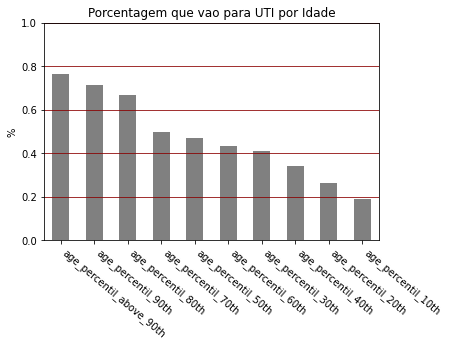

In [ ]:
ax = df_cat.loc[age_percentil, ['perc_pos']].sort_values(by='perc_pos', ascending=False).plot(kind='bar', 
                                                                                          ylabel='%',
                                                                                          color='Grey', 
                                                                                          legend=None)
plt.title('Porcentagem que vao para UTI por Idade')
plt.xticks(rotation=-40, horizontalalignment='left')
ax.grid(axis='y', color='DarkRed')
plt.ylim(0,1)
plt.show()

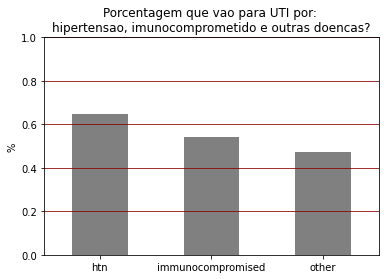

In [ ]:
ax = df_cat.loc[others, ['perc_pos']].sort_values(by='perc_pos', ascending=False).plot(kind='bar', 
                                                                                          ylabel='%',
                                                                                          color='Grey', 
                                                                                          legend=None)
plt.title('Porcentagem que vao para UTI por: \nhipertensao, imunocomprometido e outras doencas?')
plt.xticks(rotation=0)
ax.grid(axis='y', color='DarkRed')
plt.ylim(0,1)
plt.show()

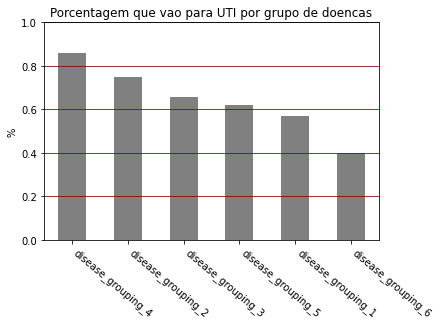

In [ ]:
ax = df_cat.loc[disease_groups, ['perc_pos']].sort_values(by='perc_pos', ascending=False).plot(kind='bar', 
                                                                                          ylabel='%',
                                                                                          color='Grey', 
                                                                                          legend=None)
plt.title('Porcentagem que vao para UTI por grupo de doencas')
plt.xticks(rotation=-40, horizontalalignment='left')
ax.grid(axis='y', color='DarkRed')
plt.ylim(0,1)
plt.show()

# ML

## Separando dados de treino e teste

In [ ]:
semente()
# removendo algumas coluna que acredito que nao vao ajudar no modelo
X = clean_data.drop(['patient_visit_identifier', 'window', 'icu'], axis=1)
# selecionando coluna de resultados
y = clean_data['icu']
# deixei o test_size padrao
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Roda Modelos

In [ ]:
# selecionando alguns modelo pra utilizar na funcao 'roda_modelo()'
modelos = [DummyClassifier('stratified'), 
           RidgeClassifier(), 
           LogisticRegression(), 
           DecisionTreeClassifier(), 
           RandomForestClassifier(),
           ]
nome = ['dummy_cl', 'ridge_cl', 'log_regr', 'dec_tree', 'rd_forst']

In [ ]:
result = {}
for n in range(len(modelos)):
    r = roda_modelo(modelos[n], X, y)
    result[nome[n]] = r

S_result = pd.Series(result, name='accuracy_score')
print('---------------------\nDO MELHOR PARA O PIOR\n---------------------')
display(S_result.sort_values(ascending=False))
print('---------------------')


---------------------
DO MELHOR PARA O PIOR
---------------------


rd_forst    0.818182
ridge_cl    0.818182
log_regr    0.806818
dec_tree    0.636364
dummy_cl    0.579545
Name: accuracy_score, dtype: float64

---------------------


In [ ]:
# Gradient Bootsing Classifier
semente()
modelo = ensemble.GradientBoostingClassifier().fit(X, y)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
accuracy_score(y_test, y_pred)

0.7272727272727273

In [ ]:
# Random Forest Classifier
semente()
modelo = ensemble.RandomForestClassifier(criterion='gini').fit(X, y)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
accuracy_score(y_test, y_pred)

0.7954545454545454

# Plot confusion matrix - modelo random forest

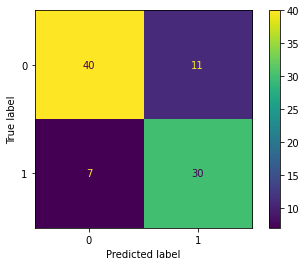


sklearn.ensemble._forest
              precision    recall  f1-score   support

           0       0.85      0.78      0.82        51
           1       0.73      0.81      0.77        37

    accuracy                           0.80        88
   macro avg       0.79      0.80      0.79        88
weighted avg       0.80      0.80      0.80        88



In [ ]:
plot_confusion_matrix(modelo, X_test, y_test)
plt.show()
print()
print(modelo.__module__)
print(classification_report(y_test, y_pred))

# cross validation with RepeatedStratifiedKFold

In [ ]:
cv = RepeatedStratifiedKFold(random_state=semente())
result = cross_validate(modelo, X, y, cv=cv, scoring='roc_auc', return_train_score=True)
S_auc = pd.Series(name='random_forest')
S_auc['mean'] = np.mean(result['test_score'])
# S_auc['mean_train'] = np.mean(result['train_score'])
S_auc['std'] = np.std(result['test_score'])
S_auc['max'] = S_auc['mean'] + 2 * S_auc['std'] 
S_auc['min'] = S_auc['mean'] - 2 * S_auc['std']  
S_auc

mean    0.791558
std     0.041805
max     0.875167
min     0.707948
Name: random_forest, dtype: float64

In [ ]:
S_auc[['max', 'mean', 'min', 'std']]

max     0.875167
mean    0.791558
min     0.707948
std     0.041805
Name: random_forest, dtype: float64